In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ~/semantic_uncertainty/semantic_uncertainty

/home/cutter/semantic_uncertainty/semantic_uncertainty


In [3]:
import numpy as np
import random
import itertools
import umap
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
import wandb
import pickle

from uncertainty.data.data_utils import load_ds
from uncertainty.utils import utils
from compute_uncertainty_measures import main as main_compute

from analyze_results import analyze_run
from uncertainty.uncertainty_measures.p_ik import get_p_ik
from uncertainty.uncertainty_measures.semantic_entropy import get_semantic_ids
from uncertainty.uncertainty_measures.semantic_entropy import logsumexp_by_id
from uncertainty.uncertainty_measures.semantic_entropy import predictive_entropy
from uncertainty.uncertainty_measures.semantic_entropy import predictive_entropy_rao
from uncertainty.uncertainty_measures.semantic_entropy import cluster_assignment_entropy
from uncertainty.uncertainty_measures.semantic_entropy import context_entails_response
from uncertainty.uncertainty_measures.semantic_entropy import EntailmentDeberta
from uncertainty.uncertainty_measures.semantic_entropy import EntailmentGPT4
from uncertainty.uncertainty_measures.semantic_entropy import EntailmentGPT35
from uncertainty.uncertainty_measures.semantic_entropy import EntailmentGPT4Turbo
from uncertainty.uncertainty_measures.semantic_entropy import EntailmentLlama

In [4]:
parser = utils.get_parser()
args, unknown = parser.parse_known_args()

In [5]:
args.num_generations = 10
args.use_context = False

In [6]:
experiment_details = {'args': args}
random.seed(args.random_seed)

In [7]:
# Get accuracy metric.
metric = utils.get_metric(args.metric)

# Load dataset.
train_dataset, validation_dataset = load_ds(
    args.dataset, add_options=args.use_mc_options, seed=args.random_seed)

In [8]:
# Get indices of answerable and unanswerable questions and construct prompt.
answerable_indices, unanswerable_indices = utils.split_dataset(train_dataset)

if args.answerable_only:
    unanswerable_indices = []
    val_answerable, val_unanswerable = utils.split_dataset(validation_dataset)
    del val_unanswerable
    validation_dataset = [validation_dataset[i] for i in val_answerable]

prompt_indices = random.sample(answerable_indices, args.num_few_shot)
experiment_details['prompt_indices'] = prompt_indices
remaining_answerable = list(set(answerable_indices) - set(prompt_indices))

In [9]:
# Create Few-Shot prompt.
make_prompt = utils.get_make_prompt(args)
BRIEF = utils.BRIEF_PROMPTS[args.brief_prompt]
arg = args.brief_always if args.enable_brief else True
prompt = utils.construct_fewshot_prompt_from_indices(
    train_dataset, prompt_indices, BRIEF, arg, make_prompt)
experiment_details['prompt'] = prompt
experiment_details['BRIEF'] = BRIEF

In [10]:
# Initialize model.
model = utils.init_model(args)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
entailment_model = EntailmentDeberta()

In [11]:
# Grab example.
dataset = train_dataset
example = dataset[6]
question, context = example["question"], example['context']
generations = {'question': question, 'context': context}
correct_answer = example['answers']['text']

current_input = make_prompt(
context, question, None, BRIEF, args.brief_always and args.enable_brief)
local_prompt = prompt + current_input

In [17]:
full_responses = []

# We sample one low temperature answer on which we will compute the
# accuracy and args.num_generation high temperature answers which will
# be used to estimate the entropy variants.

num_generations = args.num_generations + 1

for i in range(num_generations):

    # Temperature for first generation is always `0.1`.
    temperature = 0.1 if i == 0 else args.temperature

    predicted_answer, token_log_likelihoods, embedding = model.predict(
        local_prompt, temperature)
    embedding = embedding.cpu() if embedding is not None else None

    # Only compute accuracy if question is answerable.
    compute_acc = args.compute_accuracy_at_all_temps or (i == 0)
    if correct_answer and compute_acc:
        acc = metric(predicted_answer, example, model)
    else:
        acc = 0.0  # pylint: disable=invalid-name

    if i == 0:
        print('question: '.ljust(15) + question)
        # if args.use_context:
        print('context: '.ljust(15) + str(context))
        print('low-t prediction: '.ljust(15) + predicted_answer)
        print('correct answer: '.ljust(15) + str(correct_answer))
        print('accuracy: '.ljust(15) + str(acc))

        most_likely_answer_dict = {
            'response': predicted_answer,
            'token_log_likelihoods': token_log_likelihoods,
            'embedding': embedding,
            'accuracy': acc}
        generations.update({
            'most_likely_answer': most_likely_answer_dict,
            'reference': utils.get_reference(example)})

    else:
        print('high-t prediction '.ljust(15) + str(i) + ' : ' + predicted_answer)
        # Aggregate predictions over num_generations.
        full_responses.append(
            (predicted_answer, token_log_likelihoods, embedding, acc))

# Append all predictions for this example to `generations`.
generations['responses'] = full_responses

> <string>(18)predict()

*** TypeError: monkeypatch_forward_with_steering.<locals>.custom_forward() takes from 0 to 1 positional arguments but 2 were given
*** AttributeError: 'InterruptiblePdb' object has no attribute '_disable_command_completion'
*** TypeError: monkeypatch_forward_with_steering.<locals>.custom_forward() takes from 0 to 1 positional arguments but 2 were given


In [14]:
# Compute semantic ids.
responses = [r[0] for r in full_responses]
log_liks = [r[1] for r in full_responses]
semantic_ids = get_semantic_ids(
    responses, model=entailment_model,
    strict_entailment=args.strict_entailment, example=example)
semantic_classes = {}
for i, response in enumerate(full_responses):
    if semantic_ids[i] not in semantic_classes:
        semantic_classes[semantic_ids[i]] = [response]
    else:
        semantic_classes[semantic_ids[i]].append(response)

In [16]:
entropies = defaultdict(list)

# Compute entropy from frequencies of cluster assignments.
entropies['cluster_assignment_entropy'].append(cluster_assignment_entropy(semantic_ids))

# Length normalization of generation probabilities.
log_liks_agg = [np.mean(log_lik) for log_lik in log_liks]

# Compute naive entropy.
entropies['regular_entropy'].append(predictive_entropy(log_liks_agg))

# Compute semantic entropy.
log_likelihood_per_semantic_id = logsumexp_by_id(semantic_ids, log_liks_agg, agg='sum_normalized')
pe = predictive_entropy_rao(log_likelihood_per_semantic_id)
entropies['semantic_entropy'].append(pe)

## UMAP Visualization of Embeddings for each Semantic Class

In [11]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, BoundaryNorm

In [12]:
embeddings = [r[2] for r in full_responses]
embeddings = torch.stack(embeddings)
embeddings = embeddings.squeeze()

NameError: name 'full_responses' is not defined

In [19]:
# Fit UMAP
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=3)
X_umap = reducer.fit_transform(embeddings)

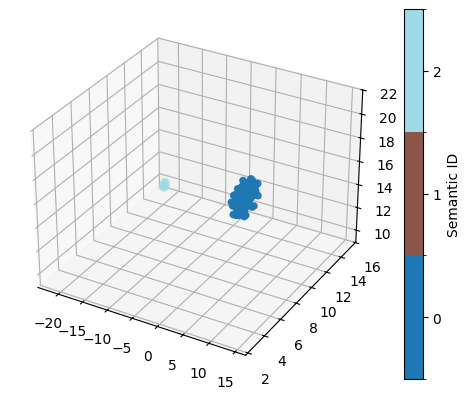

In [20]:
# Plot
fig = plt.figure()

cmap = plt.get_cmap('tab20', len(np.unique(semantic_ids))) 
norm = BoundaryNorm(np.arange(-0.5, len(np.unique(semantic_ids)) + 0.5), cmap.N)

ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c=semantic_ids, cmap=cmap, norm=norm)

cbar = fig.colorbar(sc, ax=ax, ticks=np.unique(semantic_ids))  # Set colorbar labels to semantic IDs)))
cbar.ax.set_yticklabels(np.unique(semantic_ids))  # Set colorbar labels to semantic IDs
cbar.set_label('Semantic ID')

plt.show()

In [20]:
similarities = []

for i, response_i in enumerate(generations['responses']):
    embedding_i = response_i[2]
    semantic_id_i = semantic_ids[i]
    for j, response_j in enumerate(generations['responses']):
        if i >= j:
            continue
        embedding_j = response_j[2]
        semantic_id_j = semantic_ids[j]

## Experimenting with Context Probabilities

In [6]:
import torch.nn.functional as F
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm

In [7]:
with open('/home/cutter/semantic_uncertainty/cutter/uncertainty/wandb/latest-run/files/uncertainty_measures.pkl', 'rb') as f:
    uncertainty_measures = pickle.load(f)
with open('/home/cutter/semantic_uncertainty/cutter/uncertainty/wandb/latest-run/files/validation_generations.pkl', 'rb') as f:
    validation_generations = pickle.load(f)

In [8]:
parser = utils.get_parser()
args, unknown = parser.parse_known_args()

In [9]:
args.num_generations = 10
args.use_context = False

In [173]:
# Initialize model.
model = utils.init_model(args)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 172.00 MiB. GPU 0 has a total capacity of 39.49 GiB of which 99.38 MiB is free. Including non-PyTorch memory, this process has 39.38 GiB memory in use. Of the allocated memory 38.40 GiB is allocated by PyTorch, and 503.12 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [11]:
entailment_model = EntailmentDeberta()

In [12]:
# Iterate through questions, get log probabilities and semantic entropies.
question_log_probs = []
semantic_entropies = []
for example in tqdm(validation_generations.values()):

    # Get example info.
    question, context = example["question"], example['context']
    correct_answer = example['most_likely_answer']['response']
    # question_context = 'Question: '
    full_responses = example['responses']

    # Compute question sequence log probability.
    device = model.model.device
    # x_ids = model.tokenizer(question_context, return_tensors="pt").input_ids.to(device)
    y_ids = model.tokenizer(question, return_tensors="pt").input_ids.to(device)
    z_ids = model.tokenizer(correct_answer, return_tensors="pt").input_ids.to(device)
    input_ids = torch.cat([y_ids, z_ids], dim=1).to(device)
    with torch.no_grad():
        outputs = model.model(input_ids)
    logits = outputs.logits
    log_probs = F.log_softmax(logits, dim=-1)
    token_log_probs = log_probs.gather(dim=2, index=input_ids.unsqueeze(-1)).squeeze(-1)
    seq_log_prob = token_log_probs.mean(dim=1)
    
    # Compute semantic ids.
    responses = [fr[0] for fr in full_responses]
    # responses = [f'{question} {r}' for r in responses]  # if conditioning on question
    semantic_ids = get_semantic_ids(
        responses, model=entailment_model,
        strict_entailment=args.strict_entailment, example=example)

    # Compute entropy from frequencies of cluster assignments.
    discrete_semantic_entropy = cluster_assignment_entropy(semantic_ids)

    # Length normalization of generation probabilities.
    log_liks = [r[1] for r in full_responses]
    log_liks_agg = [np.mean(log_lik) for log_lik in log_liks]

    # Compute naive entropy.
    naive_entropy = predictive_entropy(log_liks_agg)

    # Compute semantic entropy.
    log_likelihood_per_semantic_id = logsumexp_by_id(semantic_ids, log_liks_agg, agg='sum_normalized')
    semantic_entropy = predictive_entropy_rao(log_likelihood_per_semantic_id)

    # Append to lists.
    question_log_probs.append(seq_log_prob.item())
    semantic_entropies.append(semantic_entropy.item())

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [11:35<00:00,  1.74s/it]


In [20]:
full_responses[0][2].shape

torch.Size([1, 4096])

### Correlation between question log-prob and answer semantic entropy

In [26]:
corr, p_value = pearsonr(question_log_probs, semantic_entropies)

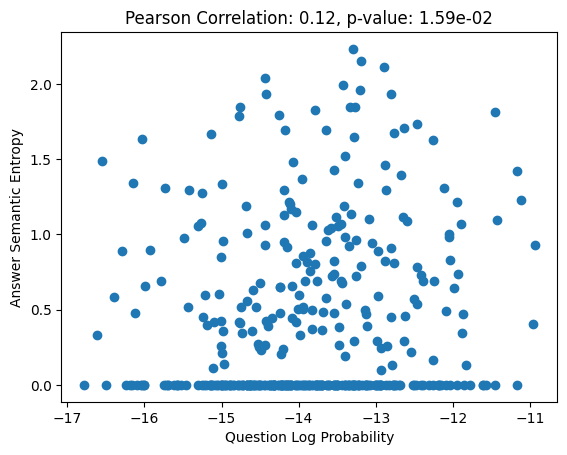

In [27]:
plt.scatter(question_log_probs, semantic_entropies)
plt.xlabel('Question Log Probability')
plt.ylabel('Answer Semantic Entropy')
plt.title(f'Pearson Correlation: {corr:.2f}, p-value: {p_value:.2e}')
plt.show()

### Experiment with linear probing

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [148]:
# Split semantic entropies into two classes: high and low semantic entropy.
threshold = 0.025
labels = [0 if se < threshold else 1 for se in semantic_entropies]

In [149]:
embeddings = []
for example in validation_generations.values():
    embedding = example['most_likely_answer']['embedding']
    embeddings.append(embedding)
embeddings = torch.stack(embeddings)
embeddings = embeddings.squeeze()

In [162]:
embeddings_train, embeddings_test, labels_train, labels_test = train_test_split(
    embeddings, labels, test_size=0.25
)

In [163]:
clf = LogisticRegression()
clf.fit(embeddings_train, labels_train)

LogisticRegression()

In [164]:
labels_pred = clf.predict(embeddings_test)
acc = accuracy_score(labels_test, labels_pred)
print(f"Test Accuracy: {acc:.2f}")

Test Accuracy: 0.67


In [165]:
probs = clf.predict_proba(embeddings_test)[:, 1]
auroc = roc_auc_score(labels_test, probs)
print(f"Test AUROC: {auroc:.2f}")

Test AUROC: 0.75


In [133]:
ratio = labels.count(0) / len(labels)
print(f"Baseline (Guessing): {ratio}")

Baseline (Guessing): 0.5325


In [168]:
# Convert labels and embeddings to numpy for indexing
labels_train = np.array(labels_train)

# Compute mean embedding for each class
mean_emb_1 = embeddings_train[labels_train == 1].mean(axis=0)
mean_emb_0 = embeddings_train[labels_train == 0].mean(axis=0)

# Compute difference vector
confabulation_vector = mean_emb_1 - mean_emb_0

In [169]:
def AcT(embedding, confabulation_vector, lam=1):
    new_embedding = embedding + lam * confabulation_vector
    return new_embedding

In [170]:
AcT(embedding, confabulation_vector)

tensor([[ 3.0638, -2.3006,  3.6650,  ..., -1.7844, -2.4310,  0.6058]])

In [172]:
print(type(model.model))

<class 'transformers.models.llama.modeling_llama.LlamaForCausalLM'>
